In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import os

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from torch.nn.parallel import DataParallel
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from datasets import load_metric

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

from huggingface_hub import login

# Login to Hugging Face Hub
login("") # insert token

2025-06-03 15:49:57.375875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-03 15:49:57.376010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-03 15:49:57.498803: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [2]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [3]:
df.shape

(416809, 3)

In [4]:
counts = df['label'].value_counts().rename_axis('Labels').reset_index(name='Count')
fig = px.bar(counts, x='Labels', y='Count', color='Labels', title='Label Counts')
fig.update_layout(xaxis_title='Labels', yaxis_title='Count')
fig.show()

In [5]:
os.environ["WANDB_DISABLED"] = "true"

class TextStratifiedData(Dataset):
    def __init__(self, df, length=None):
        if length is not None and length > df.shape[0]:
            raise ValueError("too big")
        self.length = length 
        self.df = self.stratify(df) 

    def stratify(self, df):
        # balance the dataset (min_count per class)
        min_count = df['label'].value_counts().min()
        stratified_df = df.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
        
        if self.length is not None:
            return stratified_df.sample(min(self.length, len(stratified_df)))
        else:
            return stratified_df 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.df.iloc[idx, :]
    
    def get_all(self):
        return self.df

df = TextStratifiedData(df)
df = df.get_all()


/tmp/ipykernel_26/1812968888.py:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [6]:
df.head()

,Unnamed: 0,text,label
0,195385,i never feel disturbed by you,0
1,70994,i never feel deprived because eating junk make...,0
2,335173,i feel so lonely narada,0
3,231175,i have found the perfect remedy for anyone fee...,0
4,273496,i am feeling rather melancholy about it,0


In [7]:
#remove special characters and punctuation
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

#remove extra whitespaces
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#remove non-alphanumeric characters from the 'Text' column
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,Unnamed: 0,text,label
0,195385,never feel disturbed,0
1,70994,never feel deprived eating junk makes feel bad,0
2,335173,feel lonely narada,0
3,231175,found perfect remedy anyone feeling stressed c...,0
4,273496,feeling rather melancholy,0


In [8]:
# split into 80% train, 10% validation, and 10% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

# tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")

# convert labels to numpy arrays
train_labels = train_labels.to_numpy()
val_labels = val_labels.to_numpy()
test_labels = test_labels.to_numpy()

# create datasets
train_dataset = torch.utils.data.TensorDataset(
    train_encodings["input_ids"], 
    train_encodings["attention_mask"], 
    torch.tensor(train_labels, dtype=torch.int64)
)

val_dataset = torch.utils.data.TensorDataset(
    val_encodings["input_ids"], 
    val_encodings["attention_mask"], 
    torch.tensor(val_labels, dtype=torch.int64)
)

test_dataset = torch.utils.data.TensorDataset(
    test_encodings["input_ids"], 
    test_encodings["attention_mask"], 
    torch.tensor(test_labels, dtype=torch.int64)
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred, metric):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

class CustomDataCollator:
    def __call__(self, data):
        input_ids = torch.stack([item[0] for item in data])
        attention_mask = torch.stack([item[1] for item in data])
        labels = torch.tensor([item[2] for item in data])
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

data_collator = CustomDataCollator()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, accuracy_metric),
    data_collator=data_collator,
)

# train the model
trainer.train()

val_results = trainer.evaluate()
print(f"Validation Accuracy: {val_results['eval_accuracy']}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning:

Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Epoch,Training Loss,Validation Loss,Accuracy
1,0.157600,0.125895,0.948792
2,0.111500,0.118399,0.950351
3,0.102400,0.115932,0.952020


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Validation Accuracy: 0.9520204831348102


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



Test Accuracy: 0.9496883348174533


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.




Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1468
           1       0.99      0.91      0.95      1479
           2       0.94      1.00      0.97      1568
           3       0.96      0.95      0.96      1497
           4       0.94      0.90      0.92      1547
           5       0.89      1.00      0.94      1425

    accuracy                           0.95      8984
   macro avg       0.95      0.95      0.95      8984
weighted avg       0.95      0.95      0.95      8984



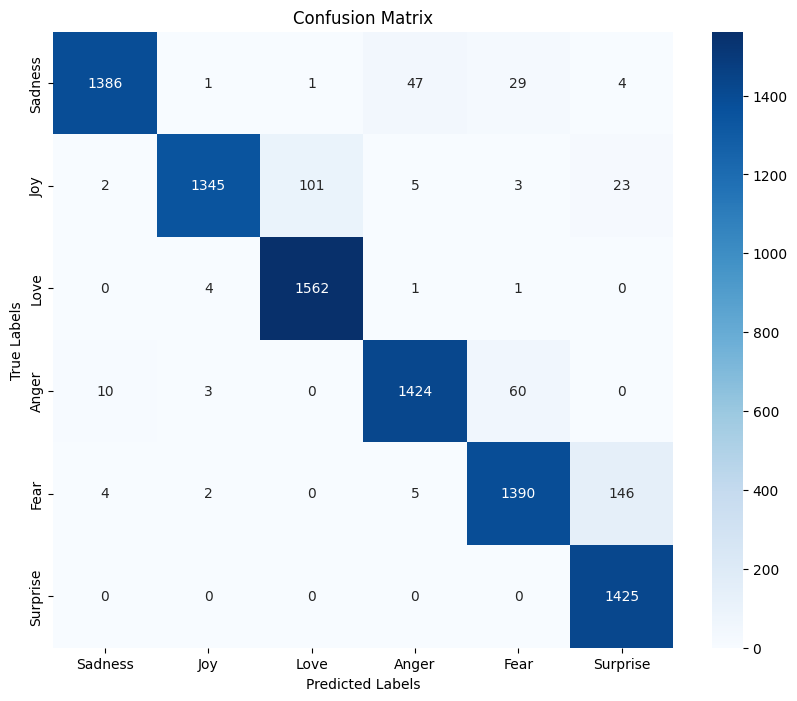

events.out.tfevents.1748967646.d5d03a5d3fcf.26.1:   0%|          | 0.00/734 [00:00<?, ?B/s]

events.out.tfevents.1748965825.d5d03a5d3fcf.26.0:   0%|          | 0.00/7.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nadchan/results/commit/43bd5ec0ba61faefdc37551023cc3c0f84836362', commit_message='Sentalysis', commit_description='', oid='43bd5ec0ba61faefdc37551023cc3c0f84836362', pr_url=None, pr_revision=None, pr_num=None)

In [9]:
test_results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {test_results['eval_accuracy']}")

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

true_labels = test_labels

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))

# confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'], 
            yticklabels=['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Pushing to Hugging Face Hub
trainer.push_to_hub("Sentalysis")